**Done in Google Colab GPU**

In [3]:
!nvidia-smi

Fri May 17 11:37:14 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
!pip install imgaug
from imgaug import augmenters as iaa
from imgaug import parameters as iap
import random
from sklearn.model_selection import train_test_split 

In [0]:
X = np.load("X.np.npy")
y = np.load("y.np.npy")

In [6]:
print(X.shape, y.shape)

(11238, 60, 80, 3) (11238,)


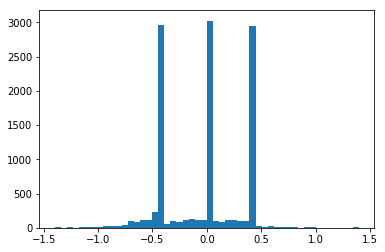

In [7]:
plt.hist(y, 50);

In [0]:
# 3 peaks are caused by driving straight ahead
# +/-0.4 was created to include left/right cameras' view

0.0


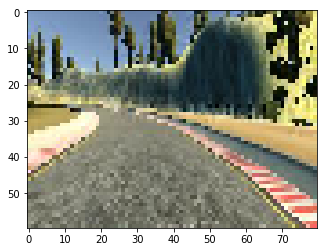

-0.35000000000000003


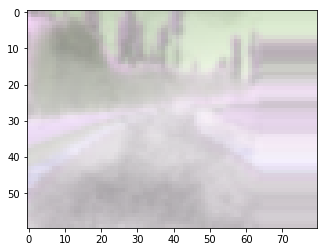

In [9]:
def augment(img, steering_angle):
  # flip
  if random.random() > 0.5:
    img = img[:, ::-1, :]
    steering_angle = -steering_angle
  # blur
  blurer = iaa.GaussianBlur(iap.Uniform(0.1, 1.0))
  img = blurer.augment_image(img)
  # RGB shuffle
  sh = iaa.ChannelShuffle(p=0.5)
  img = sh.augment_image(img)
  # fog
  fog = iaa.Fog()
  img = fog.augment_image(img)
  # translate
  tx = random.randint(-20, 20)
  translater = iaa.Affine(translate_px={"x":tx}, 
                         mode="edge")
  img = translater.augment_image(img)
  steering_angle += tx*0.025 
  return img, steering_angle  

plt.imshow(X[0])
print(y[0])
plt.show();

img, angle = augment(X[0], y[0])
plt.imshow(img)
print(angle)
plt.show();

In [0]:
X_train, X_val, y_train, y_val =  train_test_split(X, y, test_size=0.2,
                                                  random_state=42)

In [11]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(8990, 60, 80, 3) (8990,)
(2248, 60, 80, 3) (2248,)


In [12]:
Xgen = []
ygen = []
for i in range(X_train.shape[0]):
  img, angle = augment(X[i], y[i])
  Xgen.append(img)
  ygen.append(angle)

Xgen = np.array(Xgen)
ygen = np.array(ygen)
print(Xgen.shape, ygen.shape)

(8990, 60, 80, 3) (8990,)


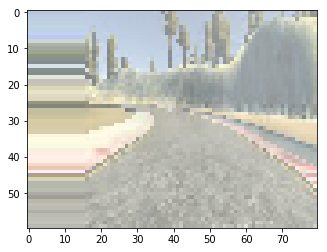

In [13]:
plt.imshow(Xgen[0]);

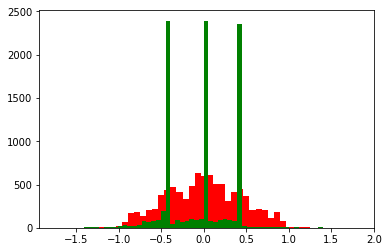

In [15]:
plt.hist(ygen, 50, facecolor="red");
plt.hist(y_train, 50, facecolor="green");

In [32]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, Lambda

!pip install livelossplot
from livelossplot import PlotLossesKeras

In [34]:
def myModel(input_shape):
  model = Sequential([
      Lambda(lambda x: (x-128.0)/255.0, input_shape=input_shape,
             name="normalize"),
      Conv2D(64, (3,3), activation="relu"),
     # MaxPooling2D(pool_size=(2,2)),
      Conv2D(32, (3,3), activation="relu"),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(16, (3,3), activation="relu"),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(8, (3,3), activation="relu"),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.5),
      Flatten(),
      Dense(512, activation="relu"),
      Dropout(rate=0.3),
      Dense(512, activation="relu"),
      Dropout(rate=0.3),
      Dense(16, activation="relu"),
      Dense(1)
  ])
  return model
model = myModel(X[0].shape)
model.summary()
model.compile("adam", "mse", )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalize (Lambda)           (None, 60, 80, 3)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 58, 78, 64)        1792      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 56, 76, 32)        18464     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 28, 38, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 26, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 13, 18, 16)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 11, 16, 8)         1160      
__________

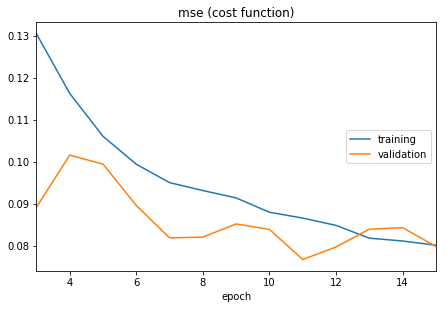

mse (cost function):
training   (min:    0.080, max:    0.189, cur:    0.080)
validation (min:    0.077, max:    0.102, cur:    0.080)


In [35]:
batch_size = 512
epochs = 15

model.fit(Xgen, ygen,
         batch_size=batch_size,
         epochs=epochs,
         validation_data=(X_val, y_val),
         callbacks=[PlotLossesKeras()])


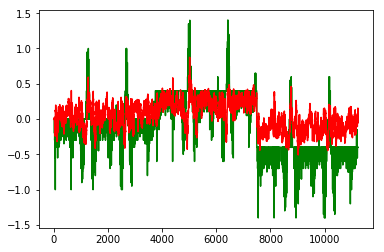

In [36]:
# see predictions vs y
ypred = model.predict(X)
plt.plot(y, "g", ypred, "r")
plt.show;

In [0]:
model.save("mymodel_1.h5")